In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [2]:
%matplotlib inline

In [14]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Dictionary to store all evaluation metrics
metrics_results = []

industries = {'agro': ['CPF.BK', 'CBG.BK', 'OSP.BK', 'ITC.BK', 'BTG.BK'], 'consump': ['AURA.BK', 'STGT.BK', 'BLC.BK', 'SNPS.BK', 'SABINA.BK'], 'fincial': ['KBANK.BK', 'KTB.BK', 'SCB.BK', 'BBL.BK', 'TISCO.BK'], 'indus': ['PTTGC.BK', 'SCGP.BK', 'IVL.BK', 'MCS.BK', 'TSTH.BK'], 'propcon': ['SCC.BK', 'CPN.BK', 'WHA.BK', 'TOA.BK', 'AP.BK'], 'resource': ['PTTEP.BK', 'BCP.BK', 'PTT.BK', 'TOP.BK', 'GPSC.BK'], 'service': ['CPALL.BK', 'AOT.BK', 'BDMS.BK', 'HMPRO.BK', 'MINT.BK'], 'tech': ['ADVANC.BK', 'TRUE.BK', 'DELTA.BK', 'CCET.BK', 'KCE.BK']}

def create_sequences(data, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Past 60 days
        y.append(data[i, 0])                    # Target: the next day’s close price

    # Convert to NumPy arrays
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

# Loop through industries and stocks
for industry, stocks in industries.items():
    for stock in stocks:
        print(f"\n Processing: {industry}/{stock}")

        model_file = os.path.join("models", industry, f"{stock}_model.keras")
        scaler_file = os.path.join("models", industry, f"{stock}_scaler.pkl")
        data_file = os.path.join("data", industry, f"{stock}.csv")
        
        if not (os.path.exists(model_file) and os.path.exists(scaler_file) and os.path.exists(data_file)):
            print(f" Model, scaler, or data not found for {stock}. Skipping...")
            continue
        
        model = load_model(model_file)
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        
        # Load the dataset
        df = pd.read_csv(data_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df[['Close']]
        
        scaled_data = scaler.transform(df)
        
        # Split into training and testing sets
        train_size = int(len(scaled_data) * 0.8)
        train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
        
        # Create sequences for testing
        x_test, y_test = create_sequences(test_data)
        
        if len(x_test) == 0 or len(y_test) == 0:
            print(f"⚠️ Not enough data for testing: {stock}. Skipping...")
            continue
        
        # Evaluate Model on Test Set
        print(f"🧪 Evaluating model for {stock}...")
        test_predictions = model.predict(x_test)
        test_predictions = scaler.inverse_transform(test_predictions)
        y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

        mse = mean_squared_error(y_test_rescaled, test_predictions)
        mae = mean_absolute_error(y_test_rescaled, test_predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test_rescaled - test_predictions) / y_test_rescaled)) * 100
        
        print(f"📈 Evaluation Metrics for {stock}:")
        print(f"   - Mean Absolute Error (MAE): {mae}")
        print(f"   - Root Mean Squared Error (RMSE): {rmse}")
        print(f"   - Mean Absolute Percentage Error (MAPE): {mape}%")

        # Store all metrics for grid table visualization
        metrics_results.append([industry, stock, mae, rmse, mape])

print("\n🎉 Prediction and evaluation complete for all stocks!")


 Processing: agro/CPF.BK
🧪 Evaluating model for CPF.BK...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
📈 Evaluation Metrics for CPF.BK:
   - Mean Absolute Error (MAE): 0.4130589313996145
   - Root Mean Squared Error (RMSE): 0.566793711241434
   - Mean Absolute Percentage Error (MAPE): 1.7913562439891104%

 Processing: agro/CBG.BK
🧪 Evaluating model for CBG.BK...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
📈 Evaluation Metrics for CBG.BK:
   - Mean Absolute Error (MAE): 3.0745087061172875
   - Root Mean Squared Error (RMSE): 3.6702911693170264
   - Mean Absolute Percentage Error (MAPE): 4.431605600641298%

 Processing: agro/OSP.BK
🧪 Evaluating model for OSP.BK...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
📈 Evaluation Metrics for OSP.BK:
   - Mean Absolute Error (MAE): 1.0944988593077047
   - Root Mean Squared Error (RMSE): 1.412976509888249
   - Mean Absolute Percentage Error (MAPE): 6.08288076894963%

 Processing: agro/ITC.BK
🧪 Evaluating model for ITC.BK...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
📈 Ev

In [33]:
metrics_df = pd.DataFrame(metrics_results, columns=['Industry', 'Stock', 'MAE', 'RMSE', 'MAPE'])

# Set the index for better visualization
metrics_df.set_index(['Industry', 'Stock'], inplace=True)

# Custom Color Mapping:
# - Green for ≤ 5 (Good Performance)
# - Orange to Red for > 5 (Poor Performance)
def color_map(val):
    if val <= 5:
        return 'background-color: #90EE90'  # Light Green
    elif val <= 10:
        return 'background-color: #FFA500'  # Orange
    else:
        return 'background-color: #FF0000'  # Red

styled_df = metrics_df.style.applymap(color_map)
styled_df

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_35286/1074744524.py:17: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = metrics_df.style.applymap(color_map)


In [8]:
metrics_results

[['agro', 'CPF.BK', 0.4130589313996145, 0.566793711241434, 1.7913562439891104],
 ['agro', 'CBG.BK', 3.0745087061172875, 3.6702911693170264, 4.431605600641298],
 ['agro', 'OSP.BK', 1.0944988593077047, 1.412976509888249, 6.08288076894963],
 ['agro', 'ITC.BK', 0.673859182393776, 0.9169944775281225, 4.2989165612102616],
 ['agro', 'BTG.BK', 1.117704424941749, 1.2842304475253619, 6.381334880638169],
 ['consump',
  'AURA.BK',
  0.47032545263117037,
  0.6650894428057634,
  3.0434637298111653],
 ['consump',
  'STGT.BK',
  0.5006179753471823,
  0.6746683117214867,
  5.1095183918314415],
 ['consump',
  'BLC.BK',
  0.21321900685628256,
  0.2294670933481967,
  5.154015438632461],
 ['consump',
  'SABINA.BK',
  0.459792513725085,
  0.6051244101155709,
  2.232243225153359],
 ['fincial',
  'KBANK.BK',
  3.1362499530498793,
  3.8820550793796644,
  2.0901220916682504],
 ['fincial',
  'KTB.BK',
  0.3483634361853966,
  0.44275068968886067,
  1.6965142697691622],
 ['fincial',
  'SCB.BK',
  1.403512977692018

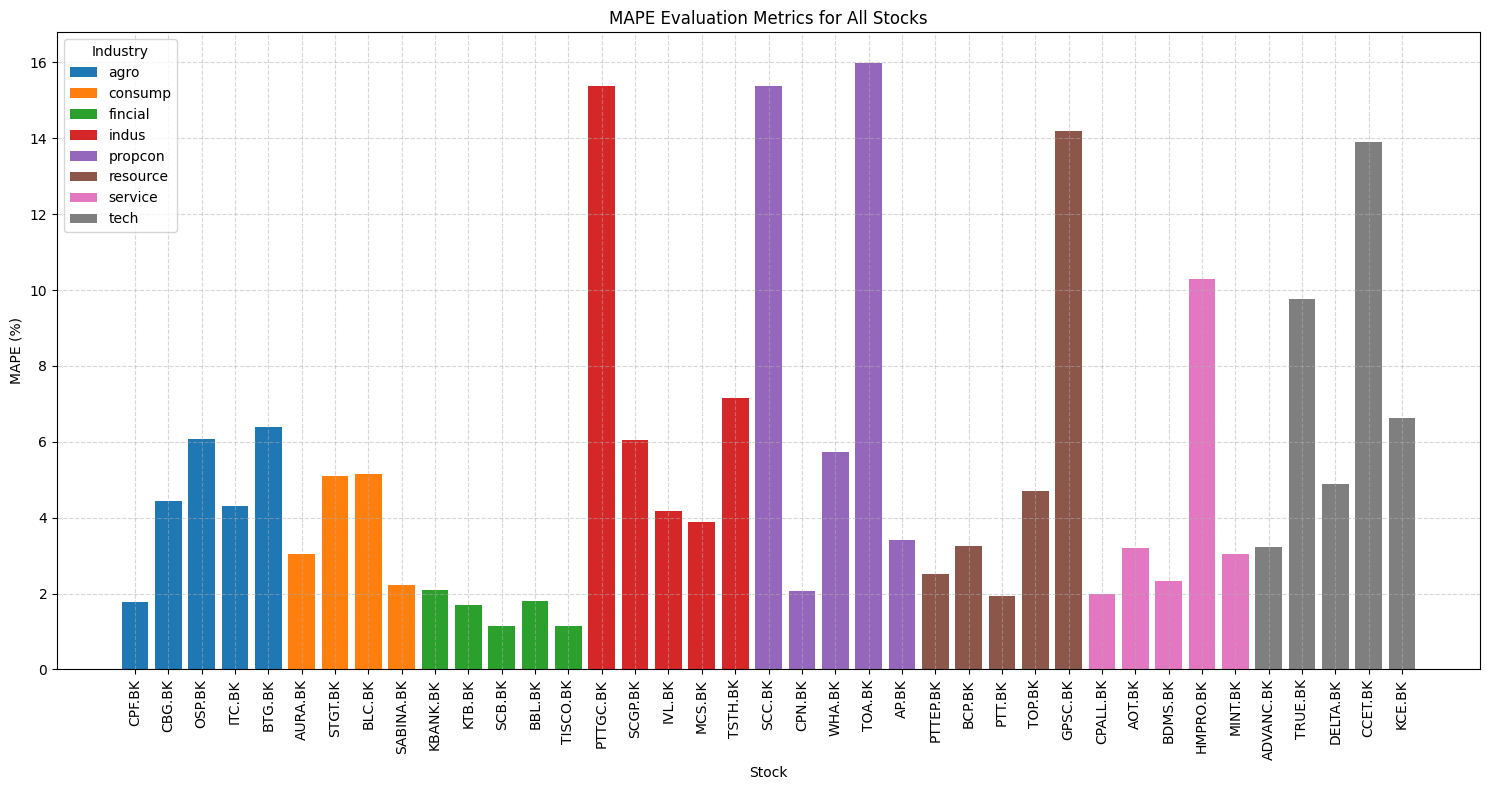

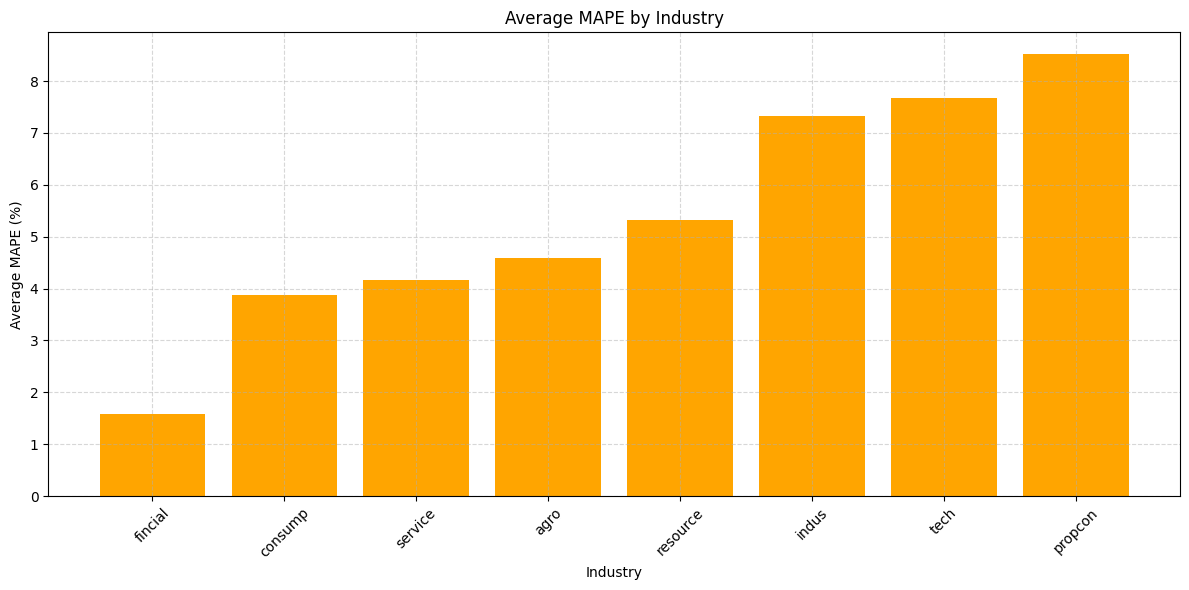

In [34]:
# Convert list to DataFrame
mape_df = pd.DataFrame(metrics_results, columns=['Industry', 'Stock', 'MAE', 'RMSE', 'MAPE'])

# Plot MAPE for each stock, grouped by industry
plt.figure(figsize=(15, 8))
for industry in mape_df['Industry'].unique():
    subset = mape_df[mape_df['Industry'] == industry]
    plt.bar(subset['Stock'], subset['MAPE'], label=industry)

plt.title('MAPE Evaluation Metrics for All Stocks')
plt.xlabel('Stock')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=90)
plt.legend(title='Industry')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Industry-wise MAPE Comparison
industry_avg_mape = mape_df.groupby('Industry')['MAPE'].mean().reset_index().sort_values(by='MAPE')

# Plot average MAPE per industry
plt.figure(figsize=(12, 6))
plt.bar(industry_avg_mape['Industry'], industry_avg_mape['MAPE'], color='orange')
plt.title('Average MAPE by Industry')
plt.xlabel('Industry')
plt.ylabel('Average MAPE (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Run individual -------------------------------------------------------

In [15]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.models import load_model

In [30]:
industry = "tech"
stock = "CCET.BK"

In [31]:
# Keras Tuner

# File paths
model_path = os.path.join("models", industry, f"{stock}_model.keras")
scaler_path = os.path.join("models", industry, f"{stock}_scaler.pkl")
data_path = os.path.join("data", industry, f"{stock}.csv")

# Load the data
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]

# Normalize
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
scaled_data = scaler.transform(df)

# Split data
train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

# Create sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    X = np.array(X).reshape(-1, sequence_length, 1)
    y = np.array(y)
    return X, y

x_train, y_train = create_sequences(train_data)

# Define model builder for Keras Tuner
def model_builder(hp):
    model = Sequential()
    lstm_units = hp.Choice('lstm_units', [32, 64, 100, 128])
    dropout_rate = hp.Choice('dropout_rate', [0.1, 0.2, 0.3])

    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=hp.Choice('dense_units', [16, 25, 50])))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set up tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name=f'tune_{stock.replace(".","_")}'
)

# Tune
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(x_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stop], batch_size=32)

# Get best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("✅ Best Hyperparameters:")
print(f"  LSTM Units: {best_hp.get('lstm_units')}")
print(f"  Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"  Dense Units: {best_hp.get('dense_units')}")

# Evaluate best model
print(f"\n🧪 Evaluating best model for {stock}...")

test_predictions = best_model.predict(x_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_rescaled, test_predictions)
mae = mean_absolute_error(y_test_rescaled, test_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_rescaled - test_predictions) / y_test_rescaled)) * 100

print(f"\n📈 Evaluation Metrics for {stock}:")
print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
print(f"   - Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   - Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

# Save best model
# best_model.save(model_path)
# print(f"✅ Best model saved to: {model_path}")

Trial 5 Complete [00h 01m 17s]
val_loss: 0.0001282843149965629

Best val_loss So Far: 0.00010901218047365546
Total elapsed time: 00h 07m 47s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Best Hyperparameters:
  LSTM Units: 128
  Dropout Rate: 0.3
  Dense Units: 16

🧪 Evaluating best model for CCET.BK...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step

📈 Evaluation Metrics for CCET.BK:
   - Mean Absolute Error (MAE): 0.1603
   - Root Mean Squared Error (RMSE): 0.2094
   - Mean Absolute Percentage Error (MAPE): 5.8358%


In [27]:
# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]

# Reshape last_60_days to fit the model input shape
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

# Generate predictions
predictions = []
for _ in range(30):
    pred = model.predict(x_future) # Predict the next day
    predictions.append(pred[0,0]) # Append the prediction to the list

    # Update x_future by removing the first value and appending the prediction at the end
    x_future = np.append(x_future[:, 1:, :], np.array([[pred[0, 0]]]).reshape(1, 1, 1), axis=1)

# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Convert predictions to a DataFrame
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

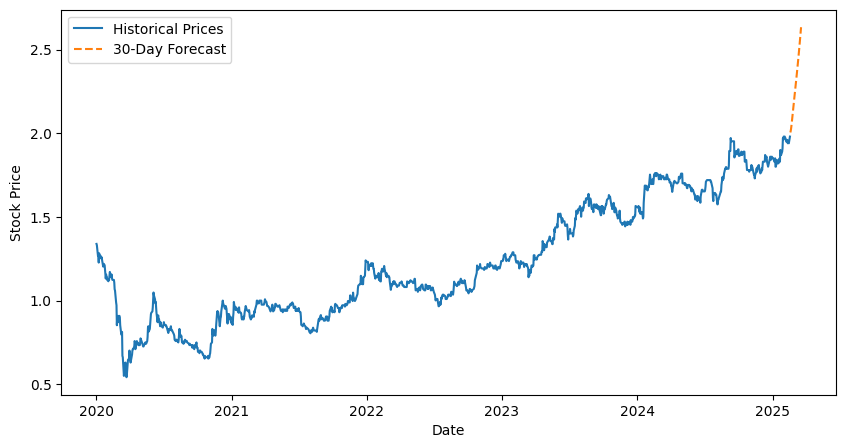

In [28]:
# Plot historical data and future predictions for comparison
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Historical Prices')
plt.plot(predictions_df, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

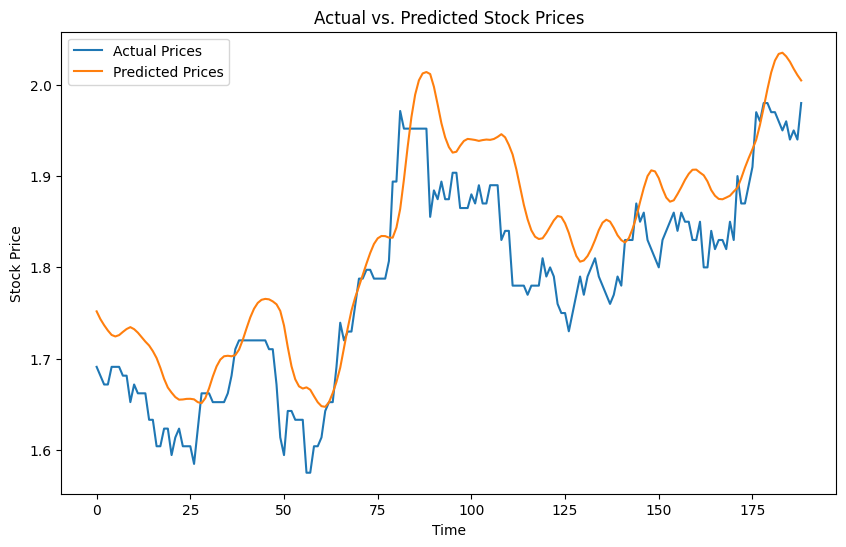

In [29]:
# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()